<a href="https://colab.research.google.com/github/Preksha100128/Titanic_Survival_Prediction_Project/blob/main/Titanic_Survival_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# To know number of columns and rows
train.shape
# (891, 12)

(891, 12)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

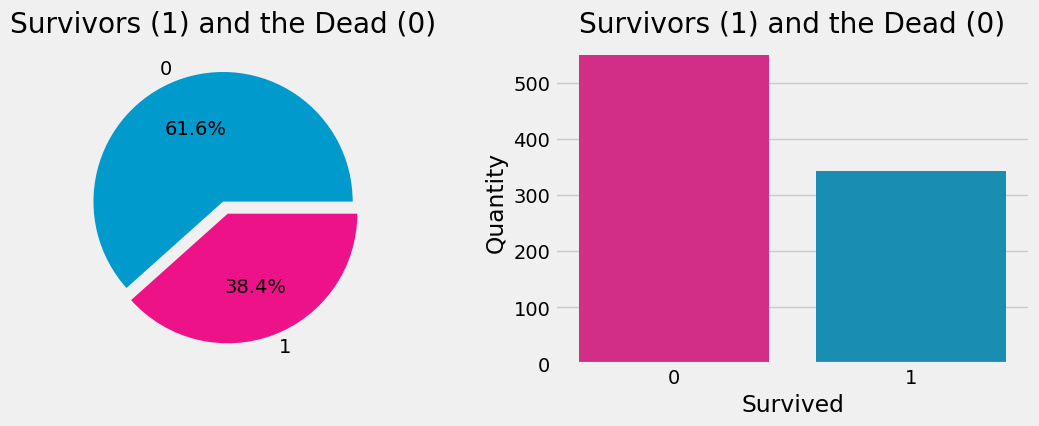

In [7]:
pie_colors = ['#009ACD', '#EE1289']
f, ax = plt.subplots(1, 2, figsize=(12, 4))
train['Survived'].value_counts().plot.pie(
    explode=[0, 0.1],
    autopct='%1.1f%%',
    ax=ax[0],
    shadow=False,
    colors=pie_colors)
ax[0].set_title('Survivors (1) and the Dead (0)')
ax[0].set_ylabel('')
countplot_colors = ['#EE1289', '#009ACD']
sns.countplot(x='Survived', data=train, ax=ax[1],palette=countplot_colors)  # Provide 'x' parameter here
ax[1].set_ylabel('Quantity')
ax[1].set_title('Survivors (1) and the Dead (0)')
plt.show()


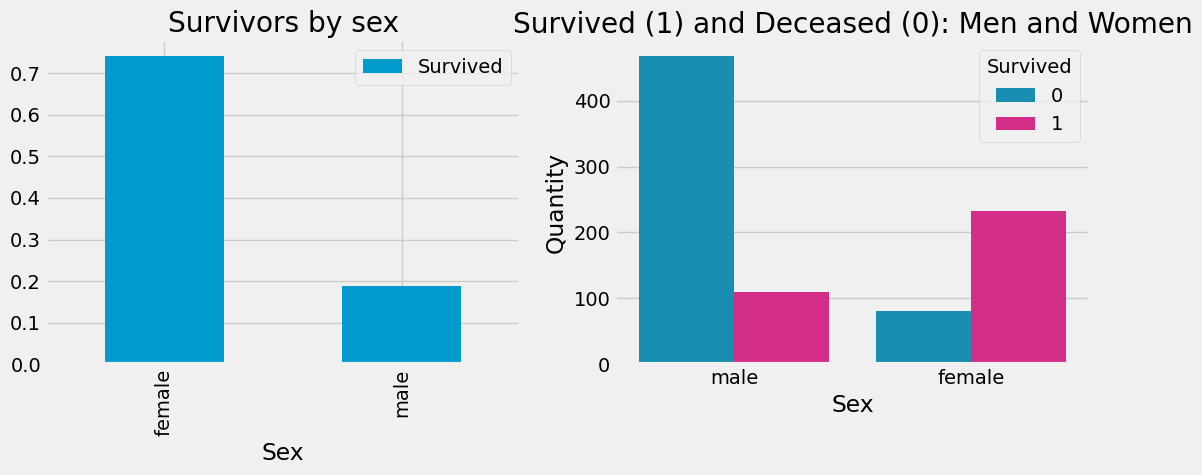

In [8]:
bar_colors = ['#009ACD', '#EE1289']
f, ax = plt.subplots(1, 2, figsize=(12, 4))
train[['Sex', 'Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0], color=bar_colors)
ax[0].set_title('Survivors by sex')
countplot_colors = ['#009ACD', '#EE1289']
sns.countplot(x='Sex', hue='Survived', data=train, ax=ax[1], palette=countplot_colors)
ax[1].set_ylabel('Quantity')
ax[1].set_title('Survived (1) and Deceased (0): Men and Women')
plt.show()


In [9]:
# Create a new column cabinbool indicating
# if the cabin value was given or was NaN
train["CabinBool"] = (train["Cabin"].notnull().astype('int'))
test["CabinBool"] = (test["Cabin"].notnull().astype('int'))

# Delete the column 'Cabin' from test
# and train dataset
train = train.drop(['Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)


In [10]:
train = train.drop(['Ticket'], axis=1)
test = test.drop(['Ticket'], axis=1)


In [11]:
# replacing the missing values in
# the Embarked feature with S
train = train.fillna({"Embarked": "S"})


In [12]:
# sort the ages into logical categories
train["Age"] = train["Age"].fillna(-0.5)
test["Age"] = test["Age"].fillna(-0.5)
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Unknown', 'Baby', 'Child', 'Teenager',
		'Student', 'Young Adult', 'Adult', 'Senior']
train['AgeGroup'] = pd.cut(train["Age"], bins, labels=labels)
test['AgeGroup'] = pd.cut(test["Age"], bins, labels=labels)


In [13]:
# create a combined group of both datasets
combine = [train, test]

# extract a title for each Name in the
# train and test datasets
for dataset in combine:
	dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train['Title'], train['Sex'])

# replace various titles with more common names
for dataset in combine:
	dataset['Title'] = dataset['Title'].replace(['Lady', 'Capt', 'Col',
												'Don', 'Dr', 'Major',
												'Rev', 'Jonkheer', 'Dona'],
												'Rare')

	dataset['Title'] = dataset['Title'].replace(
		['Countess', 'Lady', 'Sir'], 'Royal')
	dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
	dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
	dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

# map each of the title groups to a numerical value
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3,
				"Master": 4, "Royal": 5, "Rare": 6}
for dataset in combine:
	dataset['Title'] = dataset['Title'].map(title_mapping)
	dataset['Title'] = dataset['Title'].fillna(0)


In [14]:
mr_age = train[train["Title"] == 1]["AgeGroup"].mode() # Young Adult
miss_age = train[train["Title"] == 2]["AgeGroup"].mode() # Student
mrs_age = train[train["Title"] == 3]["AgeGroup"].mode() # Adult
master_age = train[train["Title"] == 4]["AgeGroup"].mode() # Baby
royal_age = train[train["Title"] == 5]["AgeGroup"].mode() # Adult
rare_age = train[train["Title"] == 6]["AgeGroup"].mode() # Adult

age_title_mapping = {1: "Young Adult", 2: "Student",
					3: "Adult", 4: "Baby", 5: "Adult", 6: "Adult"}

for x in range(len(train["AgeGroup"])):
	if train["AgeGroup"][x] == "Unknown":
		train["AgeGroup"][x] = age_title_mapping[train["Title"][x]]

for x in range(len(test["AgeGroup"])):
	if test["AgeGroup"][x] == "Unknown":
		test["AgeGroup"][x] = age_title_mapping[test["Title"][x]]


In [15]:
# map each Age value to a numerical value
age_mapping = {'Baby': 1, 'Child': 2, 'Teenager': 3,
			'Student': 4, 'Young Adult': 5, 'Adult': 6,
			'Senior': 7}
train['AgeGroup'] = train['AgeGroup'].map(age_mapping)
test['AgeGroup'] = test['AgeGroup'].map(age_mapping)

train.head()

# dropping the Age feature for now, might change
train = train.drop(['Age'], axis=1)
test = test.drop(['Age'], axis=1)


In [16]:
train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)


In [17]:
sex_mapping = {"male": 0, "female": 1}
train['Sex'] = train['Sex'].map(sex_mapping)
test['Sex'] = test['Sex'].map(sex_mapping)

embarked_mapping = {"S": 1, "C": 2, "Q": 3}
train['Embarked'] = train['Embarked'].map(embarked_mapping)
test['Embarked'] = test['Embarked'].map(embarked_mapping)


In [18]:
for x in range(len(test["Fare"])):
	if pd.isnull(test["Fare"][x]):
		pclass = test["Pclass"][x] # Pclass = 3
		test["Fare"][x] = round(
			train[train["Pclass"] == pclass]["Fare"].mean(), 4)

# map Fare values into groups of
# numerical values
train['FareBand'] = pd.qcut(train['Fare'], 4,
							labels=[1, 2, 3, 4])
test['FareBand'] = pd.qcut(test['Fare'], 4,
						labels=[1, 2, 3, 4])

# drop Fare values
train = train.drop(['Fare'], axis=1)
test = test.drop(['Fare'], axis=1)


In [19]:
from sklearn.model_selection import train_test_split

# Drop the Survived and PassengerId
# column from the trainset
predictors = train.drop(['Survived', 'PassengerId'], axis=1)
target = train["Survived"]
x_train, x_val, y_train, y_val = train_test_split(
	predictors, target, test_size=0.2, random_state=0)


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

randomforest = RandomForestClassifier()

# Fit the training data along with its output
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_val)

# Find the accuracy score of the model
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_randomforest)


83.24


In [21]:
ids = test['PassengerId']
predictions = randomforest.predict(test.drop('PassengerId', axis=1))

# set the output as a dataframe and convert
# to csv file named resultfile.csv
output = pd.DataFrame({'PassengerId': ids, 'Survived': predictions})
output.to_csv('resultfile.csv', index=False)
